# 2022-MM-DD_001__NAME

## H2 heading

### H3 heading

You can put description, notes, anything.
The idea is that one runs the first cell to initiate, the second cell to set modulation waveforms, the third cell to acquire data.

This supports Markdown: **bold**, _underscored_, [links](https://strath.ac.uk) as well as <span style="color: #1fa774">HTML</span> and even external images.

<img src="https://www.strath.ac.uk/media/1newwebsite/documents/brand/strath_main.jpg" alt="Strathy logo" width="100" height="100"> 

- Running single cell: Ctrl+Enter
- Running single cell and move to next one: Shift+Enter

# Scripts & data

In [3]:
isHot = True
isSaving = isHot and True
datadir = 'data'
figsdir = 'figs'

# Native libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import sys
from time import sleep
from datetime import datetime
from time import sleep
from tqdm import tqdm
import lzma
import warnings
import os
datadir_full = os.path.join(os.getcwd(),datadir)
import sys
sys.path.insert(0,'C:/git/StrathLab/libs') #Lab PC
sys.path.insert(0,'D:/Repositories/StrathLab/libs') #XMG
from IPython.display import Markdown #for text coloring

# Instrument libraries
try:
    from RsInstrument import BinFloatFormat
    import RsInstrument as rs
    import pyvisa as visa
    import pyarbtools
    display (Markdown('<span style="color: #1fa774">All instrument control libraries found and loaded.</span>'))
except:
    display (Markdown('<span style="color: #e17701;font-weight:bold">At least one of the instrument library failed to load. Remote control of lab equipment is not operational.</span>'))

# Custom libraries
import StrathLabToolkit as lab
from StrathLabToolkit import Find_Nearest

# Initiate remote control for lab instruments
awg = None
rth = None
sm = None

if isHot:
    try:
        awg = pyarbtools.instruments.M8190A('130.159.91.79', port=5025, timeout=30, reset=False)
    except:
        try:
            awg = pyarbtools.instruments.M8190A('127.0.0.1', port=5025, timeout=30, reset=False)
        except:
            warnings.warn('AWG not connected.',RuntimeWarning)
            awg = lab.Mock()
    
    try:
        rth = lab.Initiate_OSC()
    except:
        warnings.warn('Oscilloscope not connected.',RuntimeWarning)
        
    try:
        sm = lab.Initiate_Keithley()
        sm.measure_current(current=0.02, auto_range=True)
        sm.apply_voltage(voltage_range=2, compliance_current=0.02)    
    except:
        warnings.warn('Keithley not connected.',RuntimeWarning)
        
else:
    awg = lab.Mock()
    rth = lab.Mock()
    sm = lab.Mock()
#%%

<span style="color: #1fa774">All instrument control libraries found and loaded.</span>

Connected to oscilloscope.
Device IDN: Rohde&Schwarz,RTP,1320.5007k08/100963,4.80.1.0
Device Options: K37,B1,B4,B10,B102,B0816



C:\Users\Antonio\Miniconda3\envs\py37_main\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: Keithley not connected.


## AWG Waveforms

<span style="color: #1fa774">Used AWG channels: </span> <span style="color:#1fa774; font-weight:bold">(1, 2)</span>.

Waveform WF1 length (samples): 3590
Waveform WF2 length (samples): 400140
- Waveform lengths matched: WF2 shortened to match WF1.
Waveform WF1 length after rounding (samples): 3000
Waveform WF2 length after rounding (samples): 3000
Sample rate is 1000.0 MSa/sec.
Information: Waveform repeated 8 times.
Information: Waveform repeated 8 times.


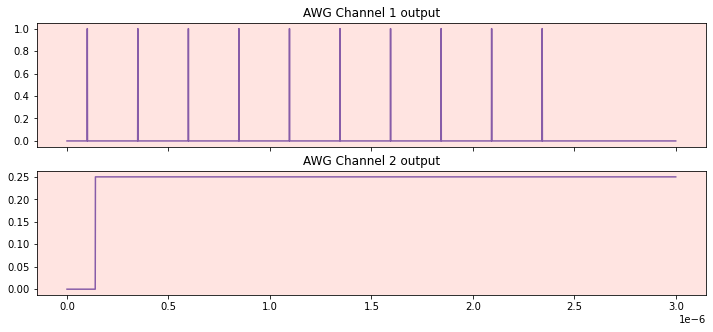

In [4]:
samplerate = 1e9 #between 125e6 and 12e9
using_AWG_channels = (1,2) # Denominate used channels: (1,),(2,),(1,2)
wf_rounding_factor = 1000 # Rounds waveform length to (ideally) avoid high repetitions during AWG synthesis

#### IMPORTANT!!!!: Sets voltage for AWG outputs
ch1_type = 'dac' # 'dac' (direct) or 'dc' (amplified)
ch1_voltage = 0.2  # in volts

ch2_type = 'dac' # 'dac' (direct) or 'dc' (amplified)
ch2_voltage = 0.1

# Note: variables that contain 'ch1_' or 'ch2_' are auto-saved with each measurement
# Therefore, if you want any mod parameters to be saved, make sure their name includes channel reference

################################
display (Markdown('<span style="color: #1fa774">Used AWG channels: </span> <span style="color:#1fa774; font-weight:bold">'+str(using_AWG_channels)+'</span>.'))
# CHANNEL 1
if 1 in using_AWG_channels:
    ##### CHANGE WF FROM HERE
    ch1_pulse_length_sa = 1
    ch1_trigseparation = 250e-9
    ch1_wf1amp = 1
    ch1_pulse_count = 10
    ch1_separator = 1000e-9
    ch1_offset_A = 0
    
    wf1_y = np.zeros(100+int(ch1_offset_A*samplerate))

    for ii in range(ch1_pulse_count):
        sep = ch1_trigseparation-(ch1_pulse_length_sa/samplerate)
        wf1_y = np.concatenate((wf1_y,
                              np.ones(int(ch1_pulse_length_sa))*ch1_wf1amp,
                              np.zeros(int(sep*samplerate))))

    wf1_y = np.concatenate((wf1_y,np.zeros(int(ch1_separator*samplerate)))) 
    
    ##### CHANGE WF TO HERE
    wf1len = wf1_y.shape[0]
    print(f'Waveform WF1 length (samples): {wf1_y.shape[0]}')
    
################################
# CHANNEL 2
if 2 in using_AWG_channels:
    ch2_step_len = 1/10e3
    ch2_levels = (0.25,0.5,0.75,1)
    ch2_wf2amp = 1
    
    offset_B = 40e-9
    zerolvl = 0

    wf2_y = np.ones(100+int(offset_B*samplerate))*zerolvl
    for level in ch2_levels:
        wf2_y = np.concatenate((wf2_y,
                              np.ones(int(samplerate*ch2_step_len))*ch2_wf2amp*level#,
                              #np.ones(int(samplerate*step_len))*0
                              ))
    #### Change to here    
    wf2len = wf2_y.shape[0]    
    print(f'Waveform WF2 length (samples): {wf2_y.shape[0]}')
#wf2 = np.concatenate((wf2,np.ones(int(10*separator*samplerate))*zerolvl))    
#wf2 = wf2/np.max(wf2)

###############################
# Sends created waveform(s) to the instruments
wf1_x, wf2_x, fig = lab.Send_WFs_to_AWG(wf1=wf1_y,
                                        out1=ch1_type,
                                        ch1_V=ch1_voltage, 
                                        wf2=wf2_y, 
                                        out2=ch2_type, 
                                        ch2_V=ch2_voltage, 
                                        isHot=isHot, 
                                        awg=awg, 
                                        sr=samplerate, 
                                        channels=using_AWG_channels, 
                                        rounding_fact=wf_rounding_factor)

### Acquisition

C:\Users\Antonio\Miniconda3\envs\py37_main\lib\site-packages\ipykernel_launcher.py:34: UserWarning: File exists already! Press Enter to continue...


Proceeding with acquisiton...


<span style="color: #014d4e;font-weight:bold">Recording data into: 001_MyDataFile_MeasuringXYZ.</span>

Mod parameters (CH1) saved:
[ch1_offset_A, ch1_pulse_count, ch1_pulse_length_sa, ch1_separator, ch1_trigseparation, ch1_type, ch1_voltage, ch1_wf1amp, ]
Mod parameters (CH2) saved:
[ch2_levels, ch2_step_len, ch2_type, ch2_voltage, ch2_wf2amp, ]


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.08it/s]


Measurement saved, time: 2022/05/05, 17:16:20
Filesize: 26.9KiB


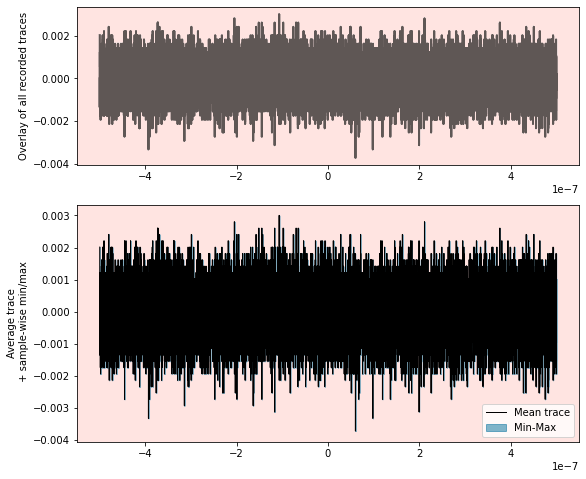

In [5]:
saved_obj = {}
#### THIS IS WHAT YOU SHOULD CHANGE ###############
fname = '001_MyDataFile_MeasuringXYZ'
acq_channel = 1  # Type: 1,2,3,4 to select oscilloscope channel
repeats = 25 # How many acquisitions in sequence should be taken

saved_obj['notes'] = '''
You can save any note you want.
It can be multiple lines.
'''

saved_obj['fname'] = fname
saved_obj['repeats'] = repeats
#### THESE ARE SAVED PARAMETERS (USING OPTIONAL, but likely helpful)###########

saved_obj['params'] = {}
#saved_obj['params']['I_{vcsel}'] = 2.200e-3
#saved_obj['params']['I_{EDFA}'] = 123e-3
#saved_obj['params']['V_{MZM}'] = 7.67
#saved_obj['params']['V_{SM_mas}'] = 0.830


##### HERE THE ACTUAL MEASURING STARTS, NO NEED TO CHANGE CODE BELOW ##########            
if isHot == True:
    
    #### Filename synthesis
    now = datetime.now()
    saved_obj['date'] = now.strftime("%Y/%m/%d, %H:%M:%S")
    full_fname = now.strftime("%Y-%m-%d")+'__'+fname+'.pkl.lz'
    full_filepath = os.path.join(datadir_full,full_fname)
    
    #### Overwrite check
    if os.path.isfile(full_filepath):
        warnings.warn("File exists already! Press Enter to continue...")
        entered = input()
        if entered != '':
            sys.exit()  
        print('Proceeding with acquisiton...')
    
    display (Markdown(f'<span style="color: #014d4e;font-weight:bold">Recording data into: {fname}.</span>'))
    
    #### Saving all modulation parameters via keywords search
    saved_obj['modulation'] = {}
    saved_obj['modulation']['samplerate'] = samplerate
    for jjj in using_AWG_channels:
        saved_obj['modulation'][f'wf{jjj}_x'] = eval(f'wf{jjj}_x')
        saved_obj['modulation'][f'wf{jjj}_y'] = eval(f'wf{jjj}_y')

        print(f'Mod parameters (CH{jjj}) saved:\n[',end='')
        saved_wf_par_counter = 0
        for var in dir():
            if f'ch{jjj}_' in var:
                saved_obj['modulation'][var] = eval(var)
                saved_wf_par_counter = saved_wf_par_counter+1
                print(var,end=', ')
        print(']')
     
    #### Saving Keithley voltage if available
    try:
        sm_I,sm_V = lab.Keithley_getReadout(sm)
        saved_obj['params']['V_sm'] = sm_V
        print(f'Keithley SM voltage: {sm_V}')
    except:
        pass
    
    #### Create plots: overlay of all measurements, mean+min/max
    figR,axR = plt.subplots(2,1,figsize=(9,8),gridspec_kw={'height_ratios':(1,1.5)})
 
    #### Get readout shape to create according arrays
    t, y = lab.Acq_OSC_Trace(rth, acq_channel)
    t = t[0:len(y)]
    y = np.asarray(y)
    ytotal = np.zeros(y.shape)
    ymin = y.copy()
    ymax = y.copy()
    saved_obj[f'measurement'] = {}
    
    #### Measure
    pbar = tqdm(total=repeats)
    #pbar.set_description()
    for jjj in range(repeats):
        xpar, y = lab.Acq_OSC_Trace(rth, acq_channel,parametric_x=True)
        xpar
        y = np.asarray(y)
        saved_obj[f'measurement'][f'{jjj}'] = {}
        saved_obj[f'measurement'][f'{jjj}']['xpar'] = xpar
        saved_obj[f'measurement'][f'{jjj}']['y'] = y
        axR[0].plot(t,y,color='xkcd:black',lw=2,alpha=1/repeats)
        ytotal = ytotal+y
        ymin = np.minimum(ymin,y)
        ymax = np.maximum(ymax,y)
        pbar.update(1)
    pbar.close()       

    #### Render mean, maximum, minimum readouts
    ytotal = ytotal/repeats     
    #axR[1].plot(t,,color='xkcd:evergreen',lw=0.5,alpha=0.5,label='Min')
    axR[1].fill_between(t,ymin,ymax,color='xkcd:ocean blue',alpha=0.5,label='Min-Max')
    axR[1].plot(t,ytotal,color='xkcd:black',lw=1,label='Mean trace')
    axR[1].legend()
    axR[0].set_facecolor((1.0, 0.47, 0.42,0.2))
    axR[1].set_facecolor((1.0, 0.47, 0.42,0.2))
    axR[0].set_ylabel('Overlay of all recorded traces')
    axR[1].set_ylabel('Average trace\n + sample-wise min/max')
    
    #### Dump mean trace into the file for convenience
    saved_obj[f'measurement']['mean'] = {}
    saved_obj[f'measurement']['mean']['xpar'] = xpar
    saved_obj[f'measurement']['mean']['y'] = ytotal
    
    #### Save everything into LZMA-compressed pickled (serialized) file
    if isSaving:
        memsize = sys.getsizeof(saved_obj)
        #print(f'Object size (memory): {memsize} [{lab.filesize_fmt(memsize)}]')
        with lzma.open(full_filepath,"wb",preset=3) as f:
            pickle.dump(saved_obj,f)
            print(f'Measurement saved, time: {saved_obj["date"]}')
        print('Filesize: '+lab.Filesize_Fmt(os.stat(full_filepath).st_size))
else:
    display (Markdown('<span style="color: #e17701;font-weight:bold">The global acquisition switch (isHot) is set to FALSE. No data recorded.</span>'))

## **Data visualization**

In [6]:
## Visualize contents of a recorded measurement
dfile = '2022-05-05__001_MyDataFile_MeasuringXYZ.pkl.lz'
with lzma.open((os.path.join(datadir_full,dfile)),"rb") as f:
    loaded_obj = pickle.load(f)
    lab.Visualise_Dict(loaded_obj)

KEY                       LEVEL           TYPE      
-------------------------------------------------------------------------------
date                      0               <class 'str'>
fname                     0               <class 'str'>
measurement               0               <class 'dict'>
  0                       1               <class 'dict'>
    xpar                  2               <class 'tuple'>
    y                     2               <class 'numpy.ndarray'>
  1                       1               <class 'dict'>
    xpar                  2               <class 'tuple'>
    y                     2               <class 'numpy.ndarray'>
  10                      1               <class 'dict'>
    xpar                  2               <class 'tuple'>
    y                     2               <class 'numpy.ndarray'>
  11                      1               <class 'dict'>
    xpar                  2               <class 'tuple'>
    y                     2             

File loading lookup phrase: <span style="color:#1fa774; font-weight:bold">MyDataFile.</span> Found files: <span style="color:#1fa774; font-weight:bold">1</span>

<span style="color: #1fa774">Loaded file:</span> <span style="color:#1fa774; font-weight:bold">2022-05-05__001_MyDataFile_MeasuringXYZ.pkl.lz</span>. <br>- Multitrace (n=25) measurement readout.


KeyError: 'meas0'

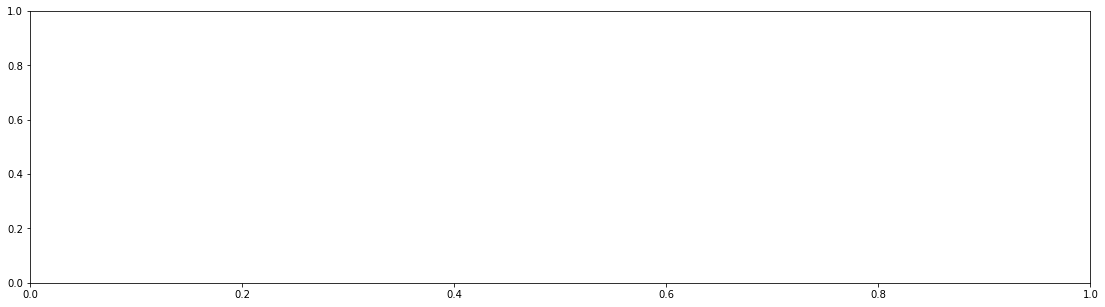

In [7]:
# MULTI-DATA VIEWER
lookup = 'MyDataFile'
x_range = (0.1,0.9)
############################
datafiles = lab.Get_Files_From_Dir(os.path.join(datadir_full))

filecounter = 0
for dfile in datafiles:
    if lookup in dfile:
        filecounter = filecounter+1  
        
if filecounter > 0:
    display (Markdown(f'File loading lookup phrase: <span style="color:#1fa774; font-weight:bold">{lookup}.</span> Found files: <span style="color:#1fa774; font-weight:bold">{filecounter}</span>'))  
    if filecounter == 1:
        figA,axA= plt.subplots(1,1,figsize=(19,5)) 
    else:
        figA,axA= plt.subplots(filecounter,1,figsize=(14,5+(filecounter-1)*3)) 
        
    figcounter = 0
    for dfile in datafiles:
        if lookup in dfile:        
            with lzma.open((os.path.join(datadir_full,dfile)),"rb") as f:
                loaded_obj = pickle.load(f) 
                repeats = loaded_obj['repeats']
                display (Markdown('<span style="color: #1fa774">Loaded file:</span> <span style="color:#1fa774; font-weight:bold">'+dfile+'</span>. <br>'+f'- Multitrace (n={repeats}) measurement readout.\n'))
                if repeats > 1:
                    ytotal = np.zeros(loaded_obj[f'meas{0}']['data_y'].shape[0])
                    
                    for jjj in range(repeats):
                        t = loaded_obj[f'meas{jjj}']['data_x']
                        ytotal = ytotal + loaded_obj[f'meas{jjj}']['data_y']    
                    
                    try:    
                        wf1 = loaded_obj['modulation']['wf1_y']
                        xax1 = loaded_obj['modulation']['wf1_x']   
                        triggers = np.where(wf1>0.5)
                    except:
                        pass
                    try:
                        wf2 = loaded_obj['modulation']['wf2_y']
                        xax2 = loaded_obj['modulation']['wf2_x'] 
                    except:
                        pass
                    
                    if filecounter > 1:
                        axA[figcounter].plot(t,ytotal,color='xkcd:dark green',lw=0.75,alpha=1,label=f'Mean trace (from n={repeats})')    
                        axA[figcounter].set_xlim((t[int(t.shape[0]*x_range[0])],t[int(t.shape[0]*x_range[1])]))                           
                        
                        axM = axA[figcounter].twinx()
                        try:
                            axM.plot(xax1[0:wf1.shape[0]],wf1,color='xkcd:indigo',alpha=0.6,lw=0.5,ls='--',label='MOD WF1') 
                        except:
                            pass
                        try:
                            axM.plot(xax2[0:wf2.shape[0]],wf2,color='xkcd:royal purple',alpha=0.6,lw=0.75,ls='-.',label='MOD WF2')
                        except:
                            pass
                        
                        axA[figcounter].legend(loc='upper left')
                        axM.legend(loc='upper right')
                    elif filecounter == 1:
                        axA.plot(t,ytotal,color='xkcd:dark green',lw=0.75,alpha=1,label=f'Mean trace (from n={repeats})')    
                        axA.set_xlim((t[int(t.shape[0]*x_range[0])],t[int(t.shape[0]*x_range[1])]))                           
                        
                        axM = axA.twinx()
                        try:
                            axM.plot(xax1[0:wf1.shape[0]],wf1,color='xkcd:indigo',alpha=0.6,lw=0.5,ls='--',label='MOD WF1') 
                        except:
                            pass
                        try:
                            axM.plot(xax2[0:wf2.shape[0]],wf2,color='xkcd:royal purple',alpha=0.6,lw=0.75,ls='-.',label='MOD WF2') 
                        except:
                            pass
                        
                        axA.legend(loc='upper left')
                        axM.legend(loc='upper right')
                        
                    figcounter = figcounter+1
else:
    display (Markdown(f'File loading lookup phrase: <span style="color:#1fa774; font-weight:bold">{lookup}.</span> Found files: <span style="color:#ff474c; font-weight:bold">{filecounter}</span>.'))

In [ ]:
## Opening a single data file for post-processing
dfile = '202X-XX-XX__001_MyDataFile_MeasuringXYZ.pkl.lz'
with lzma.open((os.path.join(datadir_full,dfile)),"rb") as f:
    loaded_obj = pickle.load(f)
    print(loaded_obj.keys())
    print()
    print(loaded_obj['modulation'].keys())
    
    #### Plotting what you want
    fig, ax = plt.subplots(2,1,figsize = (12,10)) 
    #xax_mod = np.arange(0,wf.shape[0]*1/samplerate,1/samplerate)
    wf1 = loaded_obj['modulation']['wf1']
    ax[0].plot(np.linspace(0,1,wf1.shape[0]),wf1,color='red')
    #ax[0].set_xlim((1.5e-6,6.6e-6))
    ax[0].set_title('Measurement repetitions' + str(loaded_obj['repeats']))
    
    ax[1].plot(loaded_obj['meas_MEAN']['data_x'],loaded_obj['meas_MEAN']['data_y']*1000,color='red')
    ax[1].set_title('Measurement repetitions' + str(loaded_obj['repeats']))
    
    fig.savefig('figs\\test.png')